## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
!pip install featurewiz
!pip install featurewiz --upgrade
from featurewiz import FeatureWiz
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
!pip install xgboost
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
!pip install tqdm
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Data prep

In [3]:
# Import and view summary of data
data = pd.read_csv(r"C:\Users\rm8l\Documents\data\Lu177_NET_biomarkers\Lu177_NET_biomarkers.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        188 non-null    object 
 1   Age                           188 non-null    int64  
 2   Duration                      188 non-null    int64  
 3   Site                          188 non-null    object 
 4   Grade                         188 non-null    object 
 5   Hb                            188 non-null    int64  
 6   WBC                           188 non-null    float64
 7   Platelets                     188 non-null    int64  
 8   RBC                           188 non-null    float64
 9   Neutrophils                   188 non-null    float64
 10  Lymphocyte                    188 non-null    float64
 11  Monocyte                      188 non-null    float64
 12  ESR                           188 non-null    int64  
 13  Creat

,Gender,Age,Duration,Site,Grade,Hb,WBC,Platelets,RBC,Neutrophils,...,Albumin,CRP,eGFR,CgA,Chemotherapy Type and Cycles,Liver,Skeletal,Lung,PFS,TTF
0,M,44,46,GI,G1,147,6.74,256,4.83,2.95,...,47,10.0,90,478,No,1.0,2.0,2.0,82,82
1,M,73,31,Lung,Typical,142,8.12,282,4.68,6.22,...,51,1.0,90,717,No,1.0,1.0,2.0,56,58
2,M,81,21,GI,G2,121,4.56,145,3.97,2.16,...,43,8.0,66,445,No,1.0,1.0,2.0,30,30
3,F,64,79,Pancreas,G2,143,11.73,221,4.74,9.47,...,41,0.1,90,332,Yes,1.0,2.0,2.0,17,17
4,F,53,40,GI,None,129,4.02,161,4.46,2.40,...,47,5.0,76,174,Yes,1.0,2.0,2.0,13,13


In [ ]:
data.drop(["Grade", "Site"], axis = 1, inplace = True)
# One hot encode catagorical variables (gender)
data = pd.get_dummies(data, dtype='int')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          188 non-null    int64  
 1   Duration     188 non-null    int64  
 2   Hb           188 non-null    int64  
 3   WBC          188 non-null    float64
 4   Platelets    188 non-null    int64  
 5   RBC          188 non-null    float64
 6   Neutrophils  188 non-null    float64
 7   Lymphocyte   188 non-null    float64
 8   Monocyte     188 non-null    float64
 9   ESR          188 non-null    int64  
 10  Creatinine   188 non-null    int64  
 11  Bilirubin    188 non-null    int64  
 12  ALT          188 non-null    int64  
 13  AST          188 non-null    int64  
 14  ALP          188 non-null    int64  
 15  Albumin      188 non-null    int64  
 16  CRP          188 non-null    float64
 17  eGFR         188 non-null    int64  
 18  CgA          188 non-null    int64  
 19  PFS     

,Age,Duration,Hb,WBC,Platelets,RBC,Neutrophils,Lymphocyte,Monocyte,ESR,...,AST,ALP,Albumin,CRP,eGFR,CgA,PFS,TTF,Gender_F,Gender_M
0,44,46,147,6.74,256,4.83,2.95,2.66,0.84,2,...,40,109,47,10.0,90,478,82,82,0,1
1,73,31,142,8.12,282,4.68,6.22,1.13,0.75,6,...,22,71,51,1.0,90,717,56,58,0,1
2,81,21,121,4.56,145,3.97,2.16,1.18,1.02,25,...,39,121,43,8.0,66,445,30,30,0,1
3,64,79,143,11.73,221,4.74,9.47,1.60,0.55,9,...,61,98,41,0.1,90,332,17,17,1,0
4,53,40,129,4.02,161,4.46,2.40,2.09,0.44,9,...,15,80,47,5.0,76,174,13,13,1,0


In [ ]:
# Create two dataframes, one with Time to Treatment Failure (TTF) as the target
# and another with Progression Free Survival (PFS) as the target
data_PFS = data.drop("TTF", axis = 1)
data_TTF = data.drop("PFS", axis = 1)
data_PFS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          188 non-null    int64  
 1   Duration     188 non-null    int64  
 2   Hb           188 non-null    int64  
 3   WBC          188 non-null    float64
 4   Platelets    188 non-null    int64  
 5   RBC          188 non-null    float64
 6   Neutrophils  188 non-null    float64
 7   Lymphocyte   188 non-null    float64
 8   Monocyte     188 non-null    float64
 9   ESR          188 non-null    int64  
 10  Creatinine   188 non-null    int64  
 11  Bilirubin    188 non-null    int64  
 12  ALT          188 non-null    int64  
 13  AST          188 non-null    int64  
 14  ALP          188 non-null    int64  
 15  Albumin      188 non-null    int64  
 16  CRP          188 non-null    float64
 17  eGFR         188 non-null    int64  
 18  CgA          188 non-null    int64  
 19  PFS     

## Binnning

<Axes: xlabel='PFS', ylabel='Count'>

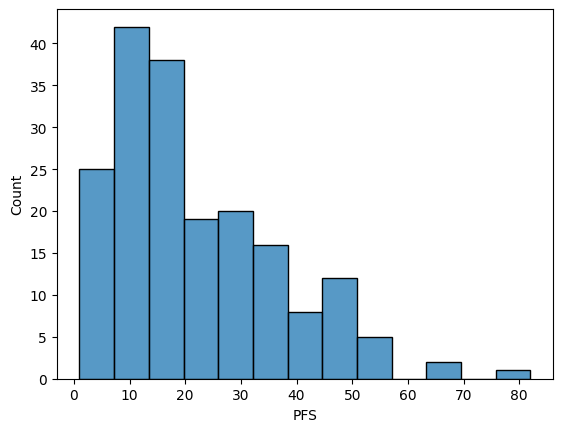

In [ ]:
# Take a look at the distribution of the PFS target
sns.histplot(data_PFS["PFS"])

<Axes: xlabel='TTF', ylabel='Count'>

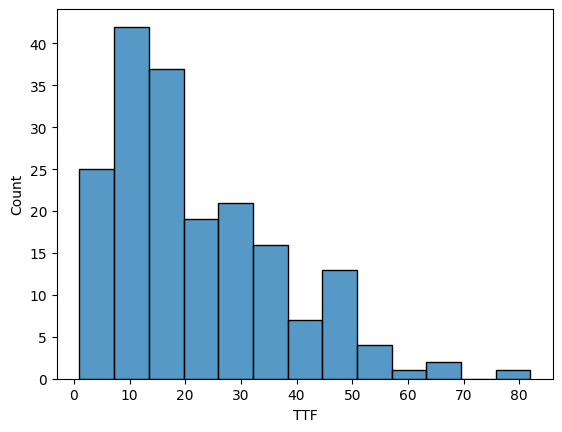

In [ ]:
# Take a look at the distribution of the TTF target
sns.histplot(data_TTF["TTF"])

Both targets are highly skewed and with very little samples in the higher value tails so it is likely that regression models would perform poorly.

Given this, descretisation of these targets using equal frequency binning will be performed to convert this into a classification task.

In [ ]:
# Create bin parameters for generating a histogram of descretised PFS target
b = 2
labels, bins = pd.qcut(data_PFS.PFS, q=b, retbins=True, precision=1)
labels.unique()

[(17.0, 82.0], (0.9, 17.0]]
Categories (2, interval[float64, right]): [(0.9, 17.0] < (17.0, 82.0]]

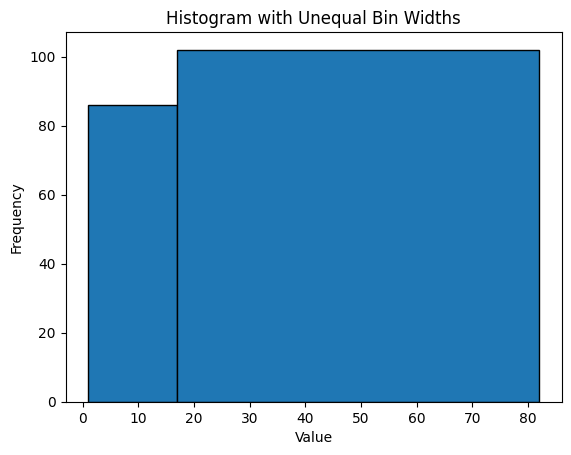

In [ ]:
# Plot histogram of descretised PFS target
plt.hist(data_PFS["PFS"], bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Unequal Bin Widths')
plt.show()

In [ ]:
# Perform equal frequency binning on the PFS dataframe, creating a
# category label column and remove the original continuous PFS data
data_PFS["PFS_cat"] = pd.qcut(data_PFS.PFS, q=b, labels = False, precision=1)
data_PFS = data_PFS.drop(['PFS'], axis=1)
data_PFS

,Age,Duration,Hb,WBC,Platelets,RBC,Neutrophils,Lymphocyte,Monocyte,ESR,...,ALT,AST,ALP,Albumin,CRP,eGFR,CgA,Gender_F,Gender_M,PFS_cat
0,44,46,147,6.74,256,4.83,2.95,2.66,0.84,2,...,121,40,109,47,10.0,90,478,0,1,1
1,73,31,142,8.12,282,4.68,6.22,1.13,0.75,6,...,23,22,71,51,1.0,90,717,0,1,1
2,81,21,121,4.56,145,3.97,2.16,1.18,1.02,25,...,35,39,121,43,8.0,66,445,0,1,1
3,64,79,143,11.73,221,4.74,9.47,1.60,0.55,9,...,110,61,98,41,0.1,90,332,1,0,0
4,53,40,129,4.02,161,4.46,2.40,2.09,0.44,9,...,12,15,80,47,5.0,76,174,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,62,48,120,4.06,158,3.96,2.74,0.91,0.32,16,...,22,32,208,46,2.0,82,142,0,1,0
184,75,76,89,5.76,262,3.02,3.46,1.84,0.36,10,...,12,13,106,31,1.0,57,3007,0,1,0
185,43,87,123,4.80,355,4.21,2.68,1.17,0.79,10,...,26,28,128,48,1.0,88,53,0,1,0
186,72,104,144,5.80,137,4.80,3.34,1.68,0.65,5,...,45,41,72,48,2.0,78,482,0,1,1


In [ ]:
# Check distribution of PFS catogaries
data_PFS["PFS_cat"].value_counts()

0    98
1    90
Name: PFS_cat, dtype: int64

In [ ]:
# Split PFS dataframe into features and target
X = data_PFS.drop(['PFS_cat'], axis=1)
y = data_PFS['PFS_cat']

# Scale features
std_scaler = StandardScaler()
MM_scaler = MinMaxScaler()
Rob_scaler = RobustScaler()
X_std_scaled = std_scaler.fit_transform(X)
X_MM_scaled = MM_scaler.fit_transform(X)
X_Rob_scaled = Rob_scaler.fit_transform(X)

## Modelling all features

In [ ]:
# Define a function that trains and tests a model using leave one out
# cross validation and returns a list of evaluation metrics

def evaluate_model(model, X, y):
    # Perform leave one out cross validation
    cv = LeaveOneOut()
    pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    # Calculate evaluation metrics
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sen = (tp) / (tp + fn)
    spec = (tn) / (tn + fp)
    ppv = (tp) / (tp + fp)
    npv = (tn) / (tn + fn)
    f1 = 2 * (sen * ppv) / (sen + ppv)
    fpr = (fp) / (fp + tn)
    tpr = (tp) / (tp + fn)

    # Creating a tuple of calculated metrics
    metrics_tuple = (model, acc, sen, spec, ppv, npv, f1, fpr, tpr)

    return metrics_tuple

In [ ]:
# Defining a function that performs LOOCV on multiple models and generates
# a sorted table of multiple performance metrics for each model

def modelling(X, y, eval) :

  # Create instances of all models we want to investigate
  LR_mod = LogisticRegression(random_state = 42)
  PTN_mod = Perceptron(random_state = 42)
  SGD_mod = SGDClassifier(random_state = 42)
  RDG_mod = RidgeClassifier(random_state = 42)
  RDGCV_mod = RidgeClassifierCV()
  DT_mod = DecisionTreeClassifier(random_state = 42)
  ET_mod = ExtraTreeClassifier(random_state = 42)
  RF_mod = RandomForestClassifier(random_state = 42)
  ETS_mod = ExtraTreesClassifier(random_state = 42)
  ADB_mod = AdaBoostClassifier(random_state = 42)
  BAG_mod = BaggingClassifier(random_state = 42)
  XGB_mod = XGBClassifier(random_state = 42)
  LFBM_mod = lgb.LGBMClassifier(random_state = 42)
  KNN_mod = KNeighborsClassifier()
  NC_mod  = NearestCentroid()
  LSVC_mod = LinearSVC(random_state = 42)
  NSVC_mod = NuSVC(random_state = 42)
  SVC_mod = SVC(random_state = 42)
  BNB_mod = BernoulliNB()
  GNB_mod = GaussianNB()

  # Create alist of defined model instances
  models = [LR_mod, PTN_mod, SGD_mod, RDG_mod, RDGCV_mod,
            DT_mod, ET_mod, RF_mod, ETS_mod, ADB_mod, BAG_mod,
            XGB_mod, LFBM_mod, KNN_mod, NC_mod, LSVC_mod, NSVC_mod,
            SVC_mod, BNB_mod, GNB_mod]

  # Create a list of model names without parentheses
  model_names = [model.__class__.__name__ for model in models]

  # Create an empty dataframe with metrics names for column headings
  metrics_names = [
          'Model', 'Accuracy', 'Sensitivity', 'Specificity',
          'Positive Predictive Value', 'Negative Predictive Value',
          'F1-score', 'False Positive Rate', 'True Positive Rate']
  all_metrics = pd.DataFrame(columns=metrics_names)

  # Perform leave one out cross validation on the list of models and populate
  # dataframe with each model and its metrics
  for model in tqdm(models, desc="Training Models", unit="model"):
      metrics = evaluate_model(model, X, y)
      metrics_series = pd.Series(metrics, index=metrics_names)
      metrics_df = metrics_series.to_frame().T
      all_metrics = pd.concat([all_metrics, metrics_df], ignore_index=True)
      print("{} - successfully trained".format(model))
  all_metrics['Model'] = model_names

  # Create the dataframe of models and their metrics
  # sorted in descending order of F1 score
  all_metrics_sorted = all_metrics.sort_values(by='Accuracy', ascending=False)
  return all_metrics_sorted

In [ ]:
# Train models on all features with no scaling
all_noscale = modelling(X, y, evaluate_model)
all_noscale

Training Models:   5%|▌         | 1/20 [00:06<01:57,  6.16s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:06<00:54,  3.02s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:07<00:34,  2.02s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:08<00:25,  1.60s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:09<00:21,  1.40s/model]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:10<00:17,  1.27s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:11<00:15,  1.22s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:46<02:23, 11.98s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:14<03:04, 16.79s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:32<02:50, 17.09s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:37<02:01, 13.50s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:26<03:15, 24.40s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:35<02:18, 19.78s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:36<01:24, 14.07s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:37<00:50, 10.05s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:41<00:32,  8.21s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:43<00:19,  6.35s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:44<00:09,  4.82s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:45<00:03,  3.62s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:46<00:00,  8.32s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
7,RandomForestClassifier,0.62766,0.622222,0.632653,0.608696,0.645833,0.615385,0.367347,0.622222
12,LGBMClassifier,0.606383,0.566667,0.642857,0.593023,0.617647,0.579545,0.357143,0.566667
6,ExtraTreeClassifier,0.601064,0.6,0.602041,0.580645,0.621053,0.590164,0.397959,0.6
11,XGBClassifier,0.601064,0.566667,0.632653,0.586207,0.613861,0.576271,0.367347,0.566667
15,LinearSVC,0.585106,0.633333,0.540816,0.558824,0.616279,0.59375,0.459184,0.633333
8,ExtraTreesClassifier,0.579787,0.577778,0.581633,0.55914,0.6,0.568306,0.418367,0.577778
9,AdaBoostClassifier,0.569149,0.566667,0.571429,0.548387,0.589474,0.557377,0.428571,0.566667
17,SVC,0.558511,0.788889,0.346939,0.525926,0.641509,0.631111,0.653061,0.788889
3,RidgeClassifier,0.558511,0.588889,0.530612,0.535354,0.58427,0.560847,0.469388,0.588889
4,RidgeClassifierCV,0.558511,0.6,0.520408,0.534653,0.586207,0.565445,0.479592,0.6


In [ ]:
# Train models on all features with standard scaling
all_stdscale = modelling(X_std_scaled, y, evaluate_model)
all_stdscale

Training Models:   5%|▌         | 1/20 [00:01<00:22,  1.18s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:01<00:13,  1.38model/s]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:02<00:10,  1.61model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:02<00:09,  1.68model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:03<00:09,  1.64model/s]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:03<00:08,  1.67model/s]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:04<00:06,  1.94model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:36<02:07, 10.59s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:00<02:44, 14.95s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:17<02:34, 15.48s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:23<01:54, 12.70s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:28<03:48, 28.57s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:34<02:30, 21.52s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:34<01:31, 15.19s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:35<00:53, 10.76s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:39<00:34,  8.67s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:39<00:18,  6.30s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:40<00:09,  4.62s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:40<00:03,  3.36s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:41<00:00,  8.06s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
7,RandomForestClassifier,0.632979,0.622222,0.642857,0.615385,0.649485,0.618785,0.357143,0.622222
13,KNeighborsClassifier,0.617021,0.6,0.632653,0.6,0.632653,0.6,0.367347,0.6
12,LGBMClassifier,0.606383,0.588889,0.622449,0.588889,0.622449,0.588889,0.377551,0.588889
6,ExtraTreeClassifier,0.601064,0.6,0.602041,0.580645,0.621053,0.590164,0.397959,0.6
11,XGBClassifier,0.595745,0.555556,0.632653,0.581395,0.607843,0.568182,0.367347,0.555556
16,NuSVC,0.590426,0.633333,0.55102,0.564356,0.62069,0.596859,0.44898,0.633333
8,ExtraTreesClassifier,0.579787,0.577778,0.581633,0.55914,0.6,0.568306,0.418367,0.577778
0,LogisticRegression,0.574468,0.611111,0.540816,0.55,0.602273,0.578947,0.459184,0.611111
14,NearestCentroid,0.574468,0.722222,0.438776,0.541667,0.632353,0.619048,0.561224,0.722222
18,BernoulliNB,0.569149,0.644444,0.5,0.542056,0.604938,0.588832,0.5,0.644444


In [ ]:
# Train models on all features with MinMax scaling
all_MMscale = modelling(X_MM_scaled, y, evaluate_model)
all_MMscale

Training Models:   5%|▌         | 1/20 [00:00<00:18,  1.02model/s]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:01<00:11,  1.56model/s]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:01<00:09,  1.77model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:02<00:08,  1.82model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:03<00:08,  1.73model/s]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:03<00:08,  1.73model/s]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:03<00:06,  1.96model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:39<02:19, 11.66s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:04<02:53, 15.74s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:21<02:43, 16.32s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:28<02:01, 13.50s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:40<04:09, 31.19s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:46<02:45, 23.62s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:47<01:39, 16.59s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:47<00:58, 11.69s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:48<00:33,  8.37s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:49<00:18,  6.13s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:49<00:08,  4.50s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:50<00:03,  3.27s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:50<00:00,  8.52s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
7,RandomForestClassifier,0.62766,0.622222,0.632653,0.608696,0.645833,0.615385,0.367347,0.622222
12,LGBMClassifier,0.611702,0.566667,0.653061,0.6,0.621359,0.582857,0.346939,0.566667
6,ExtraTreeClassifier,0.601064,0.6,0.602041,0.580645,0.621053,0.590164,0.397959,0.6
11,XGBClassifier,0.595745,0.555556,0.632653,0.581395,0.607843,0.568182,0.367347,0.555556
16,NuSVC,0.590426,0.622222,0.561224,0.565657,0.617978,0.592593,0.438776,0.622222
13,KNeighborsClassifier,0.579787,0.611111,0.55102,0.555556,0.606742,0.582011,0.44898,0.611111
8,ExtraTreesClassifier,0.579787,0.577778,0.581633,0.55914,0.6,0.568306,0.418367,0.577778
9,AdaBoostClassifier,0.569149,0.566667,0.571429,0.548387,0.589474,0.557377,0.428571,0.566667
10,BaggingClassifier,0.547872,0.466667,0.622449,0.531646,0.559633,0.497041,0.377551,0.466667
18,BernoulliNB,0.542553,0.711111,0.387755,0.516129,0.59375,0.598131,0.612245,0.711111


In [ ]:
# Train models on all features with robust scaling
all_Robscale = modelling(X_Rob_scaled, y, evaluate_model)
all_Robscale

Training Models:   5%|▌         | 1/20 [00:01<00:28,  1.49s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:01<00:15,  1.17model/s]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:02<00:11,  1.47model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:02<00:10,  1.54model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:04<00:12,  1.24model/s]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:05<00:12,  1.11model/s]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:05<00:10,  1.23model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:39<02:14, 11.19s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:04<02:51, 15.63s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:23<02:46, 16.62s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:28<01:57, 13.04s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:34<03:53, 29.25s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:41<02:36, 22.37s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:41<01:34, 15.70s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:41<00:55, 11.05s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:44<00:34,  8.51s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:45<00:18,  6.20s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:45<00:09,  4.53s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:46<00:03,  3.29s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:46<00:00,  8.33s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
7,RandomForestClassifier,0.632979,0.622222,0.642857,0.615385,0.649485,0.618785,0.357143,0.622222
12,LGBMClassifier,0.617021,0.588889,0.642857,0.602273,0.63,0.595506,0.357143,0.588889
18,BernoulliNB,0.606383,0.6,0.612245,0.586957,0.625,0.593407,0.387755,0.6
11,XGBClassifier,0.601064,0.566667,0.632653,0.586207,0.613861,0.576271,0.367347,0.566667
6,ExtraTreeClassifier,0.601064,0.6,0.602041,0.580645,0.621053,0.590164,0.397959,0.6
8,ExtraTreesClassifier,0.579787,0.577778,0.581633,0.55914,0.6,0.568306,0.418367,0.577778
14,NearestCentroid,0.574468,0.744444,0.418367,0.540323,0.640625,0.626168,0.581633,0.744444
0,LogisticRegression,0.569149,0.6,0.540816,0.545455,0.595506,0.571429,0.459184,0.6
9,AdaBoostClassifier,0.569149,0.566667,0.571429,0.548387,0.589474,0.557377,0.428571,0.566667
15,LinearSVC,0.558511,0.6,0.520408,0.534653,0.586207,0.565445,0.479592,0.6


## Feature selection

Feature selction will be performed using "Minimum Redundancy Maximum Relevance" (MRMR)
algorithm with "Searching for Uncorrelated List of Variables" method (SULOV)
[link text](https://)and recurssive XGBoost as implemented by the Featurewiz library. See https://pypi.org/project/featurewiz/

featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (188, 21)
    selecting 21 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Binary_Classification problem 
Shape of dataset: (188, 21). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 6, int_vars = 15, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
label encoder selected for transforming all categorical variables
Using My_LabelEncoder() and My_LabelEncoder() as encoders
    alert: there is no scale

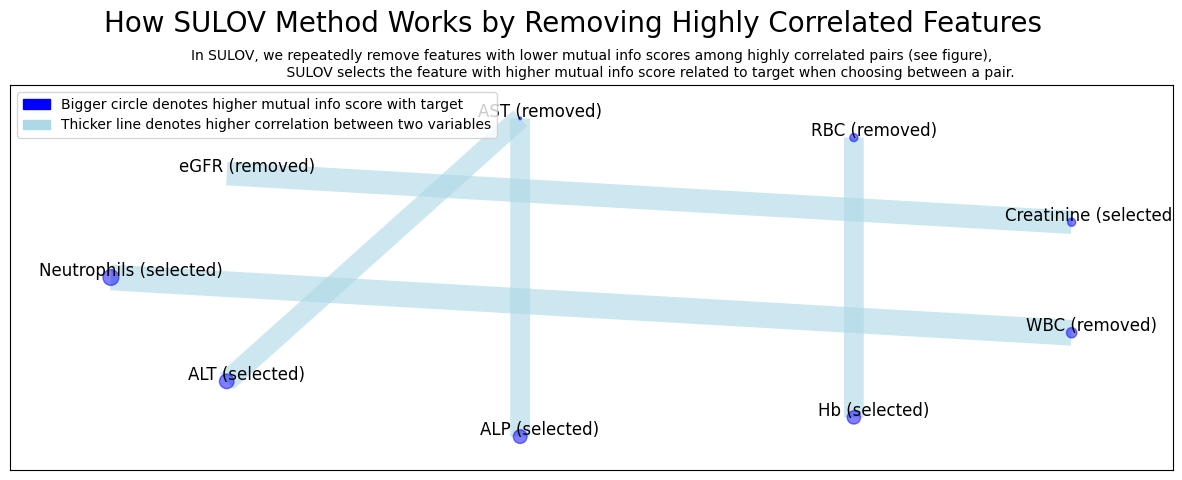

Performing recursive XGBoost feature selection from 17 features...
    Taking top 4 features per iteration...
    Number of booster rounds = 100
        Selected: ['ALP', 'Platelets', 'Lymphocyte', 'Neutrophils']
        Selected: ['ESR', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP', 'Creatinine']
        Selected: ['CgA', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP', 'Creatinine']
        Selected: ['Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP', 'Creatinine']
        Selected: ['Neutrophils', 'ALT', 'ALP', 'Hb', 'Creatinine']
        Selected: ['Hb', 'Creatinine']
    time taken to run entire featurewiz = 5 second(s)
Recursive XGBoost selected 10 features...


Index(['ALP', 'Platelets', 'Lymphocyte', 'Neutrophils', 'ESR', 'Monocyte',
       'Creatinine', 'CgA', 'ALT', 'Hb'],
      dtype='object')

In [ ]:
# Perform feature selection with no scaling
fwiz = FeatureWiz(corr_limit = 0.7, feature_engg = '', scalers="",
                  category_encoders='', verbose=1)
X_select_noscale, y = fwiz.fit_transform(X, y)

# List selected features with no scaling
X_select_noscale.columns

featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (188, 21)
    selecting 21 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Binary_Classification problem 
Shape of dataset: (188, 21). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 6, int_vars = 15, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
label encoder selected for transforming all categorical variables
Using My_LabelEncoder() and My_LabelEncoder() as encoders
Caution: ### When you hav

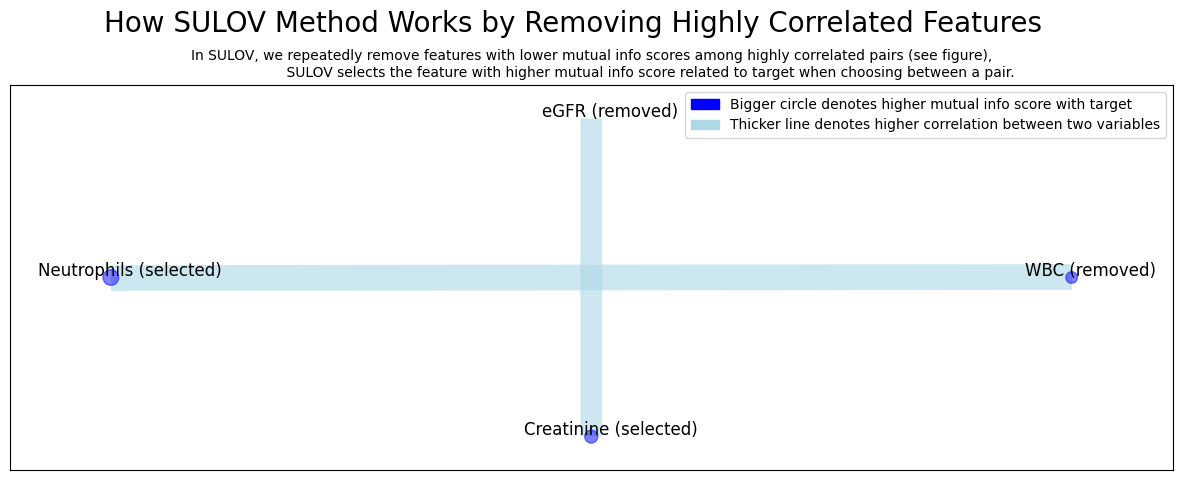

Performing recursive XGBoost feature selection from 19 features...
    Taking top 4 features per iteration...
    Number of booster rounds = 100
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['Neutrophils', 'CRP', 'Creatinine']
    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 6 features...


Index(['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'CRP', 'Creatinine'], dtype='object')

In [ ]:
# Perform feature selection with standard scaling
fwiz = FeatureWiz(corr_limit = 0.7, feature_engg = '', scalers="std",
                  category_encoders='', verbose=1)
X_select_stdscale, y = fwiz.fit_transform(X, y)

# List selected features with standard scaling
X_select_stdscale.columns

featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: [minmax]
Loaded input data. Shape = (188, 21)
    selecting 21 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Binary_Classification problem 
Shape of dataset: (188, 21). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 6, int_vars = 15, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
label encoder selected for transforming all categorical variables
Using My_LabelEncoder() and My_LabelEncoder() as encoders
Caution: ### When you 

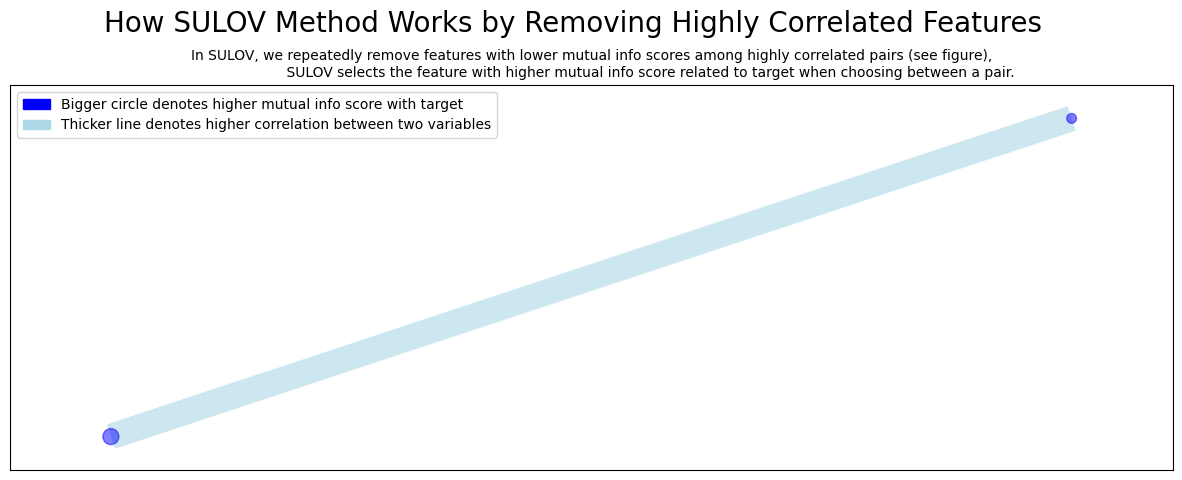

Performing recursive XGBoost feature selection from 16 features...
    Taking top 4 features per iteration...
    Number of booster rounds = 100
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils']
        Selected: ['Neutrophils', 'Lymphocyte', 'Monocyte', 'CRP']
    time taken to run entire featurewiz = 3 second(s)
Recursive XGBoost selected 5 features...


Index(['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'CRP'], dtype='object')

In [ ]:
# Perform feature selection with MinMax scaling
fwiz = FeatureWiz(corr_limit = 0.7, feature_engg = '', scalers="MinMax",
                  category_encoders='', verbose=1)
X_select_MMscale, y = fwiz.fit_transform(X, y)

# List selected features with MinMAx scaling
X_select_MMscale.columns

featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: [robust]
Loaded input data. Shape = (188, 21)
    selecting 21 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Binary_Classification problem 
Shape of dataset: (188, 21). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 6, int_vars = 15, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
label encoder selected for transforming all categorical variables
Using My_LabelEncoder() and My_LabelEncoder() as encoders
Caution: ### When you 

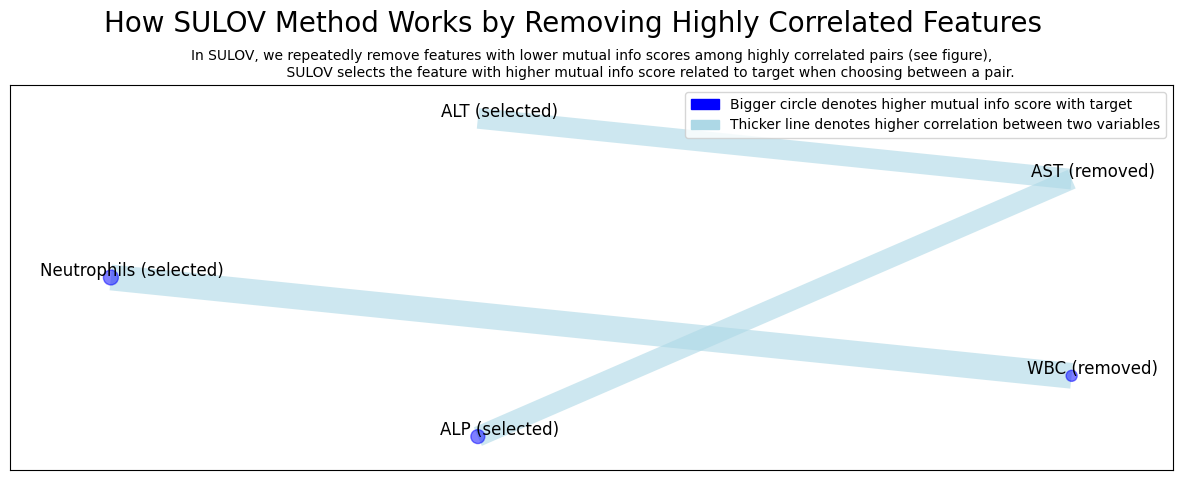

Performing recursive XGBoost feature selection from 19 features...
    Taking top 4 features per iteration...
    Number of booster rounds = 100
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP']
        Selected: ['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP']
        Selected: ['Neutrophils', 'ALP', 'ALT']
    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 6 features...


Index(['RBC', 'Lymphocyte', 'Monocyte', 'Neutrophils', 'ALP', 'ALT'], dtype='object')

In [ ]:
# Perform feature selection with robust scaling
fwiz = FeatureWiz(corr_limit = 0.7, feature_engg = '', scalers="Robust",
                  category_encoders='', verbose=1)
X_select_Robscale, y = fwiz.fit_transform(X, y)

# List selected features with robust scaling
X_select_Robscale.columns

## Modelling select features

In [ ]:
# Train models on selected features with no scaling
select_noscale = modelling(X_select_noscale, y, evaluate_model)
select_noscale

Training Models:   5%|▌         | 1/20 [00:05<01:37,  5.12s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:05<00:46,  2.58s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:06<00:30,  1.78s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:07<00:24,  1.53s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:08<00:20,  1.34s/model]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:09<00:16,  1.18s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:10<00:13,  1.04s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:43<02:12, 11.07s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:08<02:52, 15.71s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:27<02:46, 16.68s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:34<02:02, 13.63s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:17<02:59, 22.50s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:22<02:01, 17.29s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:23<01:13, 12.30s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:24<00:44,  8.81s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:26<00:27,  6.85s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:28<00:15,  5.33s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:29<00:08,  4.25s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:31<00:03,  3.38s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:32<00:00,  7.60s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
8,ExtraTreesClassifier,0.702128,0.677778,0.72449,0.693182,0.71,0.685393,0.27551,0.677778
5,DecisionTreeClassifier,0.664894,0.666667,0.663265,0.645161,0.684211,0.655738,0.336735,0.666667
7,RandomForestClassifier,0.648936,0.644444,0.653061,0.630435,0.666667,0.637363,0.346939,0.644444
11,XGBClassifier,0.62766,0.622222,0.632653,0.608696,0.645833,0.615385,0.367347,0.622222
12,LGBMClassifier,0.601064,0.566667,0.632653,0.586207,0.613861,0.576271,0.367347,0.566667
9,AdaBoostClassifier,0.579787,0.611111,0.55102,0.555556,0.606742,0.582011,0.44898,0.611111
19,GaussianNB,0.574468,0.866667,0.306122,0.534247,0.714286,0.661017,0.693878,0.866667
14,NearestCentroid,0.558511,0.833333,0.306122,0.524476,0.666667,0.643777,0.693878,0.833333
0,LogisticRegression,0.558511,0.622222,0.5,0.533333,0.590361,0.574359,0.5,0.622222
10,BaggingClassifier,0.558511,0.511111,0.602041,0.541176,0.572816,0.525714,0.397959,0.511111


In [ ]:
# Train models on selected features with standard scaling
select_stdscale = modelling(X_select_stdscale, y, evaluate_model)
select_stdscale

Training Models:   5%|▌         | 1/20 [00:01<00:30,  1.61s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:02<00:20,  1.12s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:03<00:16,  1.01model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:04<00:15,  1.03model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:05<00:14,  1.03model/s]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:05<00:12,  1.09model/s]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:06<00:11,  1.18model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:37<02:04, 10.41s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:02<02:44, 14.95s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:18<02:33, 15.32s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:23<01:50, 12.22s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:14<03:12, 24.04s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:20<02:09, 18.50s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:22<01:20, 13.35s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:23<00:49,  9.82s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:27<00:32,  8.08s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:31<00:20,  6.78s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:33<00:10,  5.28s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:34<00:04,  4.07s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:35<00:00,  7.77s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
11,XGBClassifier,0.590426,0.544444,0.632653,0.576471,0.601942,0.56,0.367347,0.544444
12,LGBMClassifier,0.574468,0.533333,0.612245,0.55814,0.588235,0.545455,0.387755,0.533333
8,ExtraTreesClassifier,0.569149,0.488889,0.642857,0.556962,0.577982,0.52071,0.357143,0.488889
10,BaggingClassifier,0.56383,0.433333,0.683673,0.557143,0.567797,0.4875,0.316327,0.433333
2,SGDClassifier,0.56383,0.533333,0.591837,0.545455,0.58,0.539326,0.408163,0.533333
7,RandomForestClassifier,0.558511,0.522222,0.591837,0.54023,0.574257,0.531073,0.408163,0.522222
13,KNeighborsClassifier,0.547872,0.566667,0.530612,0.525773,0.571429,0.545455,0.469388,0.566667
5,DecisionTreeClassifier,0.542553,0.566667,0.520408,0.520408,0.566667,0.542553,0.479592,0.566667
0,LogisticRegression,0.537234,0.511111,0.561224,0.516854,0.555556,0.513966,0.438776,0.511111
4,RidgeClassifierCV,0.531915,0.5,0.561224,0.511364,0.55,0.505618,0.438776,0.5


In [ ]:
# Train models on selected features with MixMax scaling
select_MMscale = modelling(X_select_MMscale, y, evaluate_model)
select_MMscale

Training Models:   5%|▌         | 1/20 [00:01<00:20,  1.10s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:01<00:16,  1.09model/s]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:02<00:14,  1.14model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:03<00:14,  1.09model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:05<00:17,  1.18s/model]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:06<00:17,  1.28s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:08<00:16,  1.26s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:41<02:19, 11.65s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:08<02:58, 16.23s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:25<02:45, 16.52s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:29<01:55, 12.85s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:12<02:55, 21.93s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:17<01:57, 16.74s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:18<01:12, 12.07s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:19<00:43,  8.78s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:21<00:26,  6.53s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:22<00:14,  4.95s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:23<00:07,  3.76s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:24<00:02,  2.86s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:24<00:00,  7.24s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
17,SVC,0.601064,0.466667,0.72449,0.608696,0.596639,0.528302,0.27551,0.466667
2,SGDClassifier,0.595745,0.411111,0.765306,0.616667,0.585938,0.493333,0.234694,0.411111
11,XGBClassifier,0.595745,0.555556,0.632653,0.581395,0.607843,0.568182,0.367347,0.555556
12,LGBMClassifier,0.590426,0.544444,0.632653,0.576471,0.601942,0.56,0.367347,0.544444
3,RidgeClassifier,0.574468,0.544444,0.602041,0.556818,0.59,0.550562,0.397959,0.544444
15,LinearSVC,0.569149,0.544444,0.591837,0.550562,0.585859,0.547486,0.408163,0.544444
13,KNeighborsClassifier,0.56383,0.522222,0.602041,0.546512,0.578431,0.534091,0.397959,0.522222
10,BaggingClassifier,0.547872,0.4,0.683673,0.537313,0.553719,0.458599,0.316327,0.4
18,BernoulliNB,0.547872,0.111111,0.94898,0.666667,0.537572,0.190476,0.05102,0.111111
7,RandomForestClassifier,0.547872,0.533333,0.561224,0.527473,0.56701,0.530387,0.438776,0.533333


In [ ]:
# Train models on selected features with Robust scaling
select_Robscale = modelling(X_select_Robscale, y, evaluate_model)
select_Robscale

Training Models:   5%|▌         | 1/20 [00:01<00:21,  1.15s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|█         | 2/20 [00:01<00:17,  1.03model/s]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█▌        | 3/20 [00:02<00:15,  1.09model/s]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|██        | 4/20 [00:03<00:15,  1.04model/s]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|██▌       | 5/20 [00:04<00:14,  1.01model/s]

RidgeClassifierCV() - successfully trained


Training Models:  30%|███       | 6/20 [00:05<00:13,  1.06model/s]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|███▌      | 7/20 [00:06<00:12,  1.02model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|████      | 8/20 [00:40<02:14, 11.24s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████▌     | 9/20 [01:05<02:52, 15.66s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|█████     | 10/20 [01:22<02:40, 16.04s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|█████▌    | 11/20 [01:28<01:56, 12.93s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|██████    | 12/20 [02:10<02:54, 21.84s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...) - successfully trained


Training Models:  65%|██████▌   | 13/20 [02:15<01:57, 16.80s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████   | 14/20 [02:16<01:11, 11.96s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|███████▌  | 15/20 [02:17<00:42,  8.57s/model]

NearestCentroid() - successfully trained


Training Models:  80%|████████  | 16/20 [02:19<00:26,  6.58s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████▌ | 17/20 [02:20<00:15,  5.03s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|█████████ | 18/20 [02:22<00:08,  4.12s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|█████████▌| 19/20 [02:23<00:03,  3.31s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████| 20/20 [02:24<00:00,  7.24s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
12,LGBMClassifier,0.643617,0.622222,0.663265,0.629213,0.656566,0.625698,0.336735,0.622222
7,RandomForestClassifier,0.632979,0.611111,0.653061,0.617978,0.646465,0.614525,0.346939,0.611111
18,BernoulliNB,0.62234,0.777778,0.479592,0.578512,0.701493,0.663507,0.520408,0.777778
11,XGBClassifier,0.611702,0.544444,0.673469,0.604938,0.616822,0.573099,0.326531,0.544444
9,AdaBoostClassifier,0.601064,0.633333,0.571429,0.575758,0.629213,0.603175,0.428571,0.633333
14,NearestCentroid,0.585106,0.877778,0.316327,0.541096,0.738095,0.669492,0.683673,0.877778
0,LogisticRegression,0.579787,0.633333,0.530612,0.553398,0.611765,0.590674,0.469388,0.633333
8,ExtraTreesClassifier,0.579787,0.533333,0.622449,0.564706,0.592233,0.548571,0.377551,0.533333
10,BaggingClassifier,0.579787,0.477778,0.673469,0.573333,0.584071,0.521212,0.326531,0.477778
6,ExtraTreeClassifier,0.569149,0.577778,0.561224,0.547368,0.591398,0.562162,0.438776,0.577778


## Final Model

In [ ]:
# Perform leave one out cross validation on the best combination of model and
# data  to obtian predictions
final_mod = ExtraTreesClassifier(random_state = 42)
cv = LeaveOneOut()
final_pred = cross_val_predict(final_mod, X_select_noscale, y, cv = cv, n_jobs=-1)

# Combine predicitons and actual class label into dataframe
y = np.array(y)
final_results = np.stack((y, final_pred), axis=1)
final_results = pd.DataFrame(final_results,
                   columns=['Actual', 'Predictions'])

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        98
           1       0.69      0.68      0.69        90

    accuracy                           0.70       188
   macro avg       0.70      0.70      0.70       188
weighted avg       0.70      0.70      0.70       188



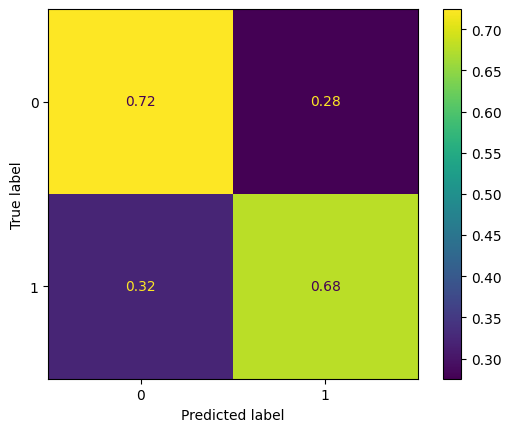

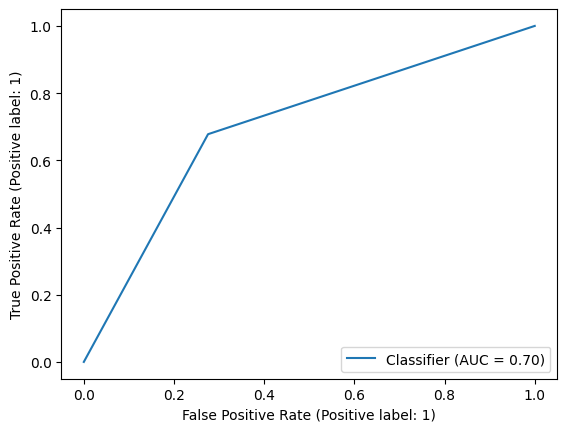

In [ ]:
# Display best model performance metrics

print(ConfusionMatrixDisplay.from_predictions(final_results['Actual'],
                                              final_results['Predictions'], normalize= "true"))

print(classification_report(final_results['Actual'],
                            final_results['Predictions']))

print(RocCurveDisplay.from_predictions(final_results['Actual'],
                                       final_results['Predictions']))